# **Import main libraries**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import math

# **Importing the Dataset**

In [8]:
# Step 1: Load the data
file_path = 'long_data_.csv'  # Path to the image file, assuming OCR extraction is done to get the data
data = pd.read_csv(file_path)

In [9]:
data.head()

,States,Regions,latitude,longitude,Dates,Unnamed: 5,Usage
0,Punjab,NR,31.519974,75.980003,2/1/2019,NaN,119.9
1,Haryana,NR,28.450006,77.019991,2/1/2019,NaN,130.3
2,Rajasthan,NR,26.449999,74.639981,2/1/2019,NaN,234.1
3,Delhi,NR,28.669993,77.230004,2/1/2019,NaN,85.8
4,UP,NR,27.599981,78.050006,2/1/2019,NaN,313.9


# **Data Cleaning**

In [10]:
# Check for missing values
print(data.isnull().sum())

States            0
Regions           0
latitude          0
longitude         0
Dates             0
Unnamed: 5    16599
Usage             0
dtype: int64


In [11]:
# Standardize the date format
data['Dates'] = data['Dates'].str.split(' ').str[0]

In [12]:
# Convert 'Dates' to datetime
data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')

In [13]:
data['Dates'].value_counts()

Dates
2019-07-11    66
2019-07-12    66
2019-07-08    66
2019-07-09    66
2019-07-10    66
              ..
2019-01-15    33
2019-01-16    33
2019-01-17    33
2019-01-18    33
2020-12-05    33
Name: count, Length: 498, dtype: int64

In [14]:
# Check data types
print(data.dtypes)

States                object
Regions               object
latitude             float64
longitude            float64
Dates         datetime64[ns]
Unnamed: 5           float64
Usage                float64
dtype: object


# **EDA**

In [15]:
# Summary statistics
print(data.describe())

           latitude     longitude                          Dates  Unnamed: 5  \
count  16599.000000  16599.000000                          16599         0.0   
mean      23.178220     81.794533  2019-09-25 13:27:18.966202624         NaN   
min        8.900373     71.192400            2019-01-02 00:00:00         NaN   
25%       19.820430     76.569993            2019-05-11 00:00:00         NaN   
50%       23.835404     78.570026            2019-09-12 00:00:00         NaN   
75%       27.333330     88.329947            2020-01-26 00:00:00         NaN   
max       33.450000     94.216667            2020-12-05 00:00:00         NaN   
std        6.146575      7.258429                            NaN         NaN   

              Usage  
count  16599.000000  
mean     103.001862  
min        0.300000  
25%        6.700000  
50%       64.400000  
75%      173.900000  
max      522.100000  
std      116.044056  


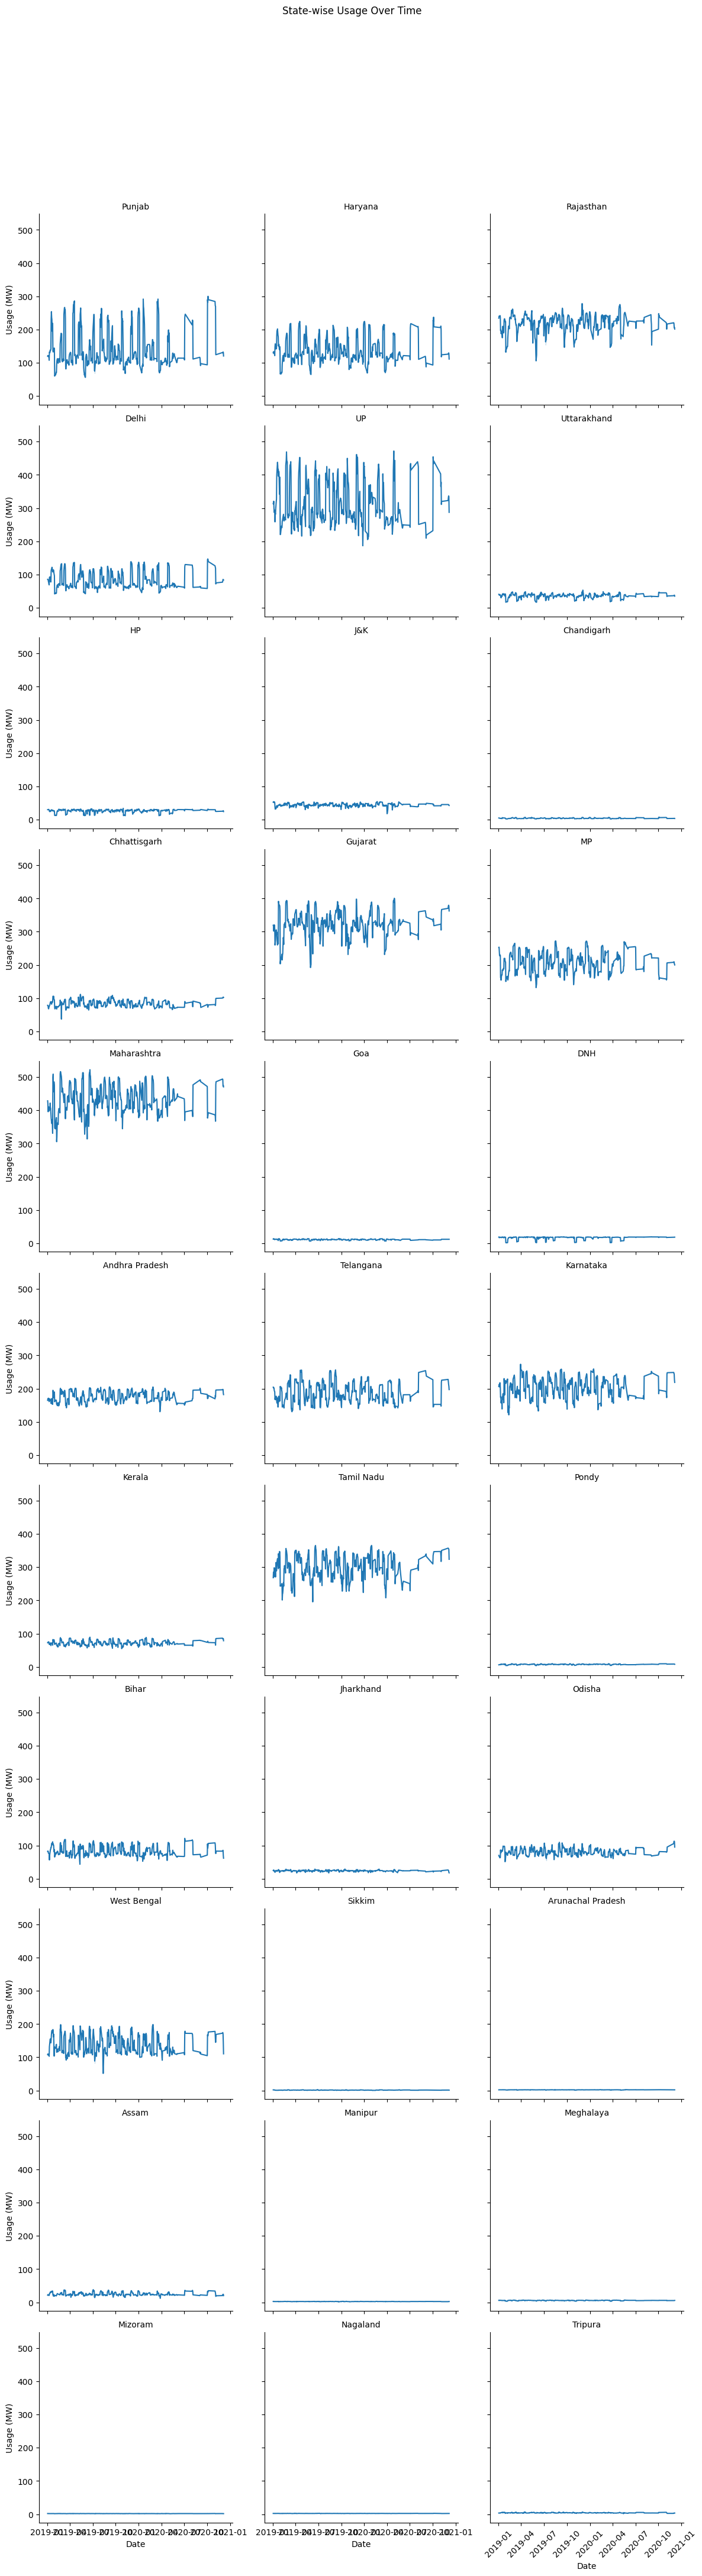

In [16]:
# Create a FacetGrid for state-wise usage over time
g = sns.FacetGrid(data, col="States", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.lineplot, 'Dates', 'Usage')

# Adjust the titles and layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels('Date', 'Usage (MW)')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('State-wise Usage Over Time', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

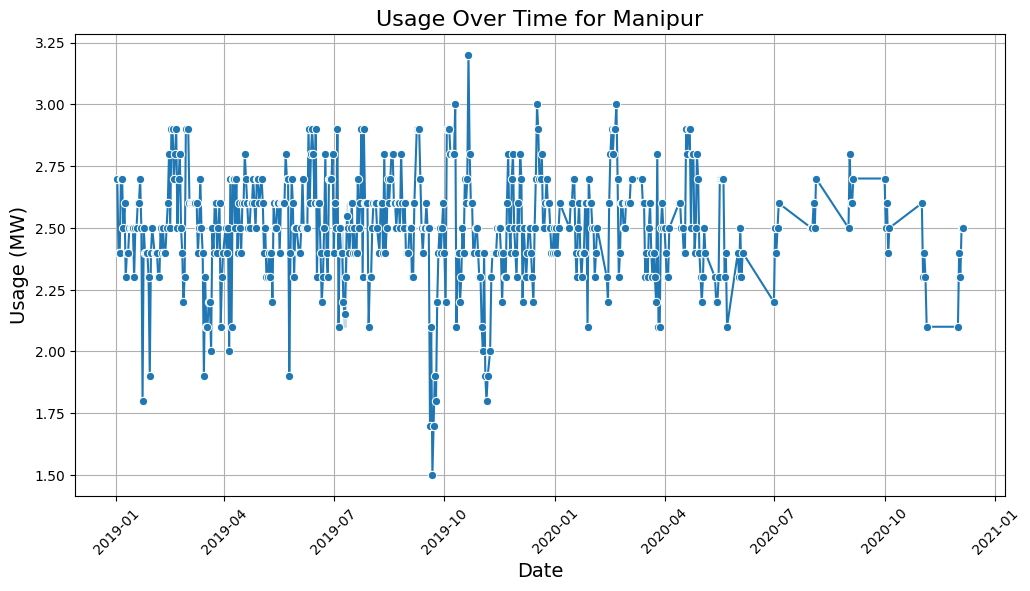

In [17]:
# Filter data for the state of Manipur
manipur_data = data[data['States'] == 'Manipur']

# Plot the line plot for Manipur's usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=manipur_data, x='Dates', y='Usage', marker='o')

# Customize the plot
plt.title('Usage Over Time for Manipur', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Usage (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


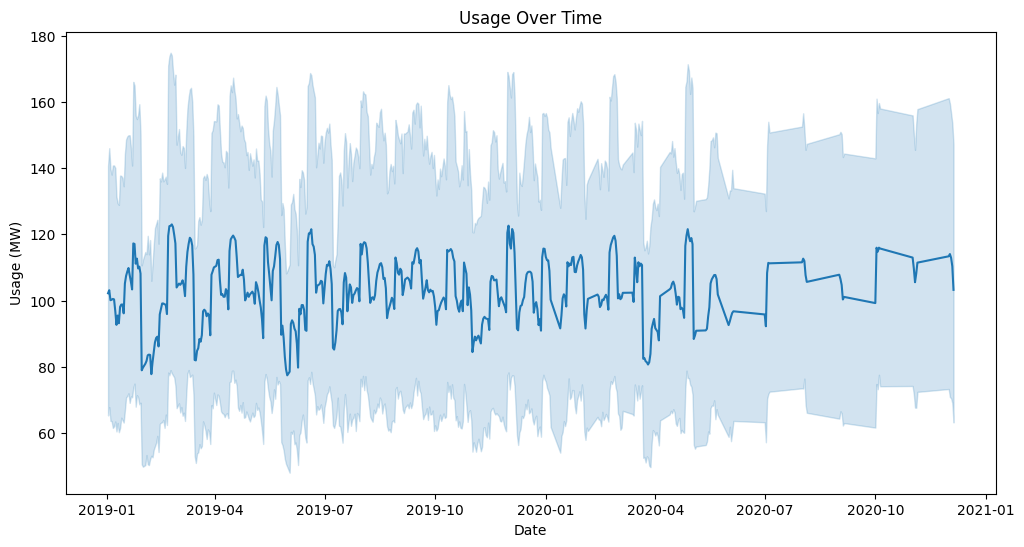

In [18]:
# Usage over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Dates', y='Usage', data=data)
plt.title('Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Usage (MW)')
plt.show()

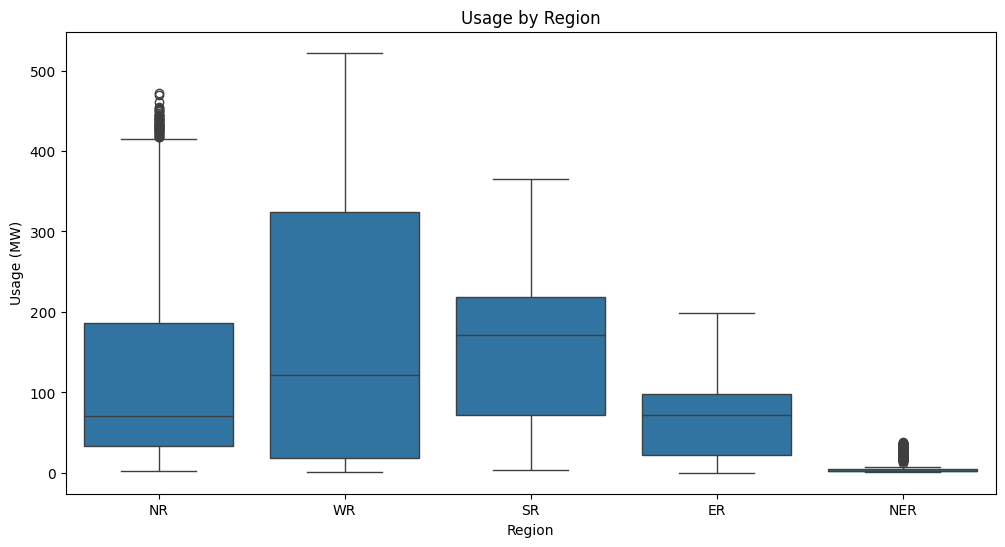

In [19]:
# Usage by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='Regions', y='Usage', data=data)
plt.title('Usage by Region')
plt.xlabel('Region')
plt.ylabel('Usage (MW)')
plt.show()

# **Data Visualization**

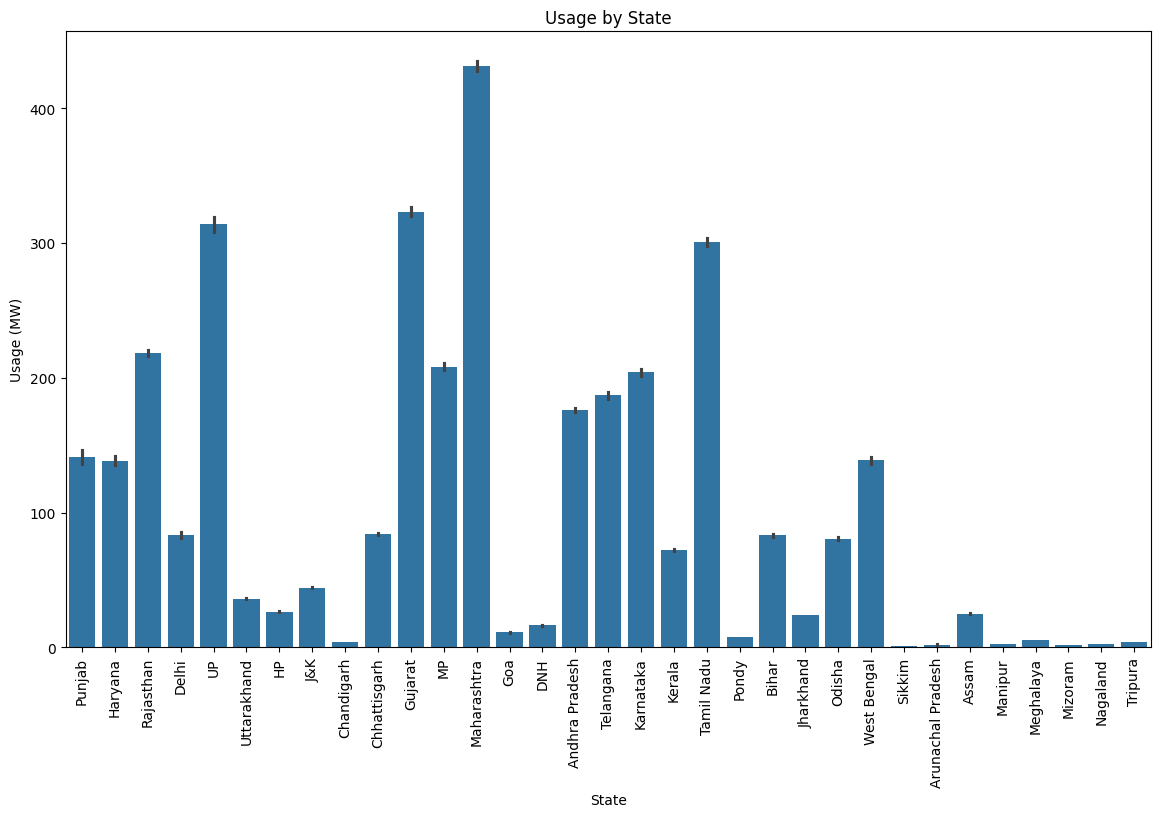

In [20]:
# Usage by state
plt.figure(figsize=(14, 8))
sns.barplot(x='States', y='Usage', data=data)
plt.title('Usage by State')
plt.xlabel('State')
plt.ylabel('Usage (MW)')
plt.xticks(rotation=90)
plt.show()

# **Feature Engineering**

In [22]:
# Extracting additional features from 'Dates'
data['Year'] = data['Dates'].dt.year
data['Month'] = data['Dates'].dt.month
data['Day'] = data['Dates'].dt.day

In [23]:
data.head()

,States,Regions,latitude,longitude,Dates,Unnamed: 5,Usage,Year,Month,Day
0,Punjab,NR,31.519974,75.980003,2019-01-02,NaN,119.9,2019,1,2
1,Haryana,NR,28.450006,77.019991,2019-01-02,NaN,130.3,2019,1,2
2,Rajasthan,NR,26.449999,74.639981,2019-01-02,NaN,234.1,2019,1,2
3,Delhi,NR,28.669993,77.230004,2019-01-02,NaN,85.8,2019,1,2
4,UP,NR,27.599981,78.050006,2019-01-02,NaN,313.9,2019,1,2


In [24]:
# One-hot encode categorical variables
encoded_data = pd.get_dummies(data, columns=['States', 'Regions'], drop_first=True)

In [25]:
print(encoded_data.shape)
encoded_data.head()

(16599, 44)


,latitude,longitude,Dates,Unnamed: 5,Usage,Year,Month,Day,States_Arunachal Pradesh,States_Assam,...,States_Tamil Nadu,States_Telangana,States_Tripura,States_UP,States_Uttarakhand,States_West Bengal,Regions_NER,Regions_NR,Regions_SR,Regions_WR
0,31.519974,75.980003,2019-01-02,NaN,119.9,2019,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
1,28.450006,77.019991,2019-01-02,NaN,130.3,2019,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
2,26.449999,74.639981,2019-01-02,NaN,234.1,2019,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
3,28.669993,77.230004,2019-01-02,NaN,85.8,2019,1,2,False,False,...,False,False,False,False,False,False,False,True,False,False
4,27.599981,78.050006,2019-01-02,NaN,313.9,2019,1,2,False,False,...,False,False,False,True,False,False,False,True,False,False


# **Model Building**

In [26]:
# Define features and target variable
X = data.drop(columns=['Usage', 'Dates'])
y = data['Usage']

In [27]:
# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['States', 'Regions'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X.shape

(13279, 44)
(3320, 44)
(13279,)
(3320,)


(16599, 44)

In [31]:
# !pip install lazypredict

In [33]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)


 98%|█████████▊| 41/42 [06:01<00:04,  4.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 13279, number of used features: 5
[LightGBM] [Info] Start training from score 102.249281


100%|██████████| 42/42 [06:01<00:00,  8.61s/it]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          0.98       0.98  15.61   
RandomForestRegressor                        0.98       0.98  16.78   
BaggingRegressor                             0.98       0.98  17.50   
XGBRegressor                                 0.98       0.98  17.88   
LGBMRegressor                                0.97       0.97  20.52   
HistGradientBoostingRegressor                0.97       0.97  20.70   
DecisionTreeRegressor                        0.97       0.97  21.07   
ExtraTreeRegressor                           0.96       0.96  23.17   
GaussianProcessRegressor                     0.96       0.96  23.87   
GradientBoostingRegressor                    0.95       0.95  25.42   
AdaBoostRegressor                            0.67       0.67  67.98   
KNeighborsRegressor                          0.60       0.60  74.60   
MLPReg

In [34]:
start_time = time.time()
# Create and train the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

end_time = time.time()
execution_time = end_time - start_time


In [35]:
print('Root Mean Squared Error:', math.sqrt(mse))
print('R-squared:', r2)
print("Execution time:", execution_time, "seconds")

Root Mean Squared Error: 18.02240809372448
R-squared: 0.9769422554446252
Execution time: 0.5877697467803955 seconds


# **Prediction**

In [36]:
def getAttributes(state):
    state_index = data[data['States'] == state].index[0]
    state_data = data.iloc[state_index]
    region = state_data['Regions']
    latitude = state_data['latitude']
    longitude = state_data['longitude']
    return region,latitude,longitude


In [37]:
def get_user_input():
    try:
        # Get user input
        state = input("Enter state: ")
        region, latitude, longitude = getAttributes(state)

        date_input = input("Enter date (in DD-MM-YYYY format): ")

        # Preprocess user input
        try:
            date = datetime.strptime(date_input, "%d-%m-%Y")
        except ValueError:
            print("Error: Date format should be DD-MM-YYYY.")
            return None

        year = date.year
        month = date.month
        day = date.day

        # Create a dictionary to store the preprocessed input
        input_data = {
            'Year': [year],
            'Month': [month],
            'Day': [day],
            'States_' + state: [1],
            'Regions_' + region: [1],
            'latitude': [latitude],
            'longitude': [longitude]
        }

        # Create a new data point for prediction
        new_data_point = pd.DataFrame(input_data)

        # Add missing state and region columns with 0 values
        states = list(data['States'].unique())
        regions = list(data['Regions'].unique())
        for state in states:
            if 'States_' + state not in new_data_point.columns:
                new_data_point['States_' + state] = 0
        for region in regions:
            if 'Regions_' + region not in new_data_point.columns:
                new_data_point['Regions_' + region] = 0

        new_data_point = new_data_point[X_train.columns]
        return new_data_point

    except Exception as e:
        print(f"An error occurred: {e}")
        exit(1)

In [ ]:
# Get user input and create a new data point for prediction
new_data_point = get_user_input()

# Make a prediction using the trained model
new_prediction = model.predict(new_data_point)

li = new_prediction.tolist()
li = [round(i,3) for i in li]

print('Predicted Usage:', li[0], 'mW')

# **Pickle file**

In [41]:
import pickle

# Assuming X_train is the training data used to fit the model
feature_names = X_train.columns.tolist()

with open('model_with_features.pkl', 'wb') as file:
    pickle.dump((model, feature_names), file)